# Тестовое задание по направлению "Data Science".

## Описание данных.

В данном проекте используется нам был предоставлен текстовый файл в формате 'DOCX', содержащий диалог с совещания. Этот файл представляет собой детализированные записи обсуждений, которые включают как текстовые сообщения участников, так и временные метки, отражающие моменты начала и завершения каждого сообщения.<br>Целью задания является всесторонний анализ текста с применением современных методов анализа данных и обработки естественного языка.<br><br>Основные шаги:<br>1. Исследовательский анализ данных (EDA);<br>2. Анализ эмоциональности текста;<br>3. Тематическое моделирование.<br><br>Такой комплексный анализ позволит глубже понять содержание совещания, выявить эмоциональные настроения участников и определить основные темы, что может, в теории, повысить эффективность принятия решений и организацию будущих обсуждений.

## 1. Исследовательский анализ данных (EDA).

### 1.1. Загрузка и очистка текстовых данных.

In [1]:
import pandas as pd
import re
from docx import Document
from collections import Counter
import nltk
from nltk.corpus import stopwords
import os
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
import gensim.corpora as corpora
import gensim.models as models
from sklearn.model_selection import train_test_split
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 

RANDOM_STATE=42
TEST_SIZE=0.2

Для начала напишем функцию для загрузки файла формата '.docx' и извлечения его содержимого. А затем присвоим результат переменной 'text'.

In [2]:
def load(file_path):
    doc = Document(file_path)
    text = []
    for para in doc.paragraphs:
        text.append(para.text)
    return '\n'.join(text)
    
text = load('/Users/nolvi/Downloads/report_24_0608_131810 (1).docx')
print("Первые 500 символов исходного текста:\n")
print(text[:500])

Первые 500 символов исходного текста:

Расшифрованный текст.
НЕ УДАЛОСЬ РАСПОЗНАТЬ СОБЕСЕДНИКОВ
[0м01с–0м03с]: Ногами пинаю. 
[0м03с–0м04с]: Тут с первой еще надо начинать. 
[0м04с–0м07с]: Ты помнишь, как все в Хамсуэте их ремонтировали? 
[0м07с–0м07с]: Да. 
[0м07с–0м08с]: А, ты не знаешь. 
[0м08с–0м08с]: Почему? 
[0м08с–0м13с]: У меня был такой мониторчик от Хампа, вот, широкий. 
[0м13с–0м15с]: Я его тоже лупил, он хорошо работал. 
[0м15с–0м15с]: Так, работай. 
[0м16с–0м20с]: Да, на всякий случай еще раз всех предупреждаю, ставим за



Сразу выполним преобразование данных в датафрейм.

In [3]:
pattern = re.compile(r'\[(\d+м\d+с)–(\d+м\d+с)\]:\s(.+)')
matches = pattern.findall(text)

df = pd.DataFrame(matches, columns=['start_time', 'end_time', 'text'])

df.head()

,start_time,end_time,text
0,0м01с,0м03с,Ногами пинаю.
1,0м03с,0м04с,Тут с первой еще надо начинать.
2,0м04с,0м07с,"Ты помнишь, как все в Хамсуэте их ремонтировали?"
3,0м07с,0м07с,Да.
4,0м07с,0м08с,"А, ты не знаешь."


Датафрейм получен, однако нам необходимо выполнить очистку текста и исправить формат временных меток (перевести в секунды).

In [4]:
def clean(text):
    text = re.sub(r'Расшифрованный текст.*', '', text)
    text = re.sub(r'НЕ УДАЛОСЬ РАСПОЗНАТЬ СОБЕСЕДНИКОВ.*', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
    
df['text'] = df['text'].apply(clean)

In [5]:
def time_to_seconds(time_str):
    minutes, seconds = re.findall(r'(\d+)м(\d+)с', time_str)[0]
    return int(minutes) * 60 + int(seconds)

In [6]:
df['start_time'] = df['start_time'].apply(time_to_seconds)
df['end_time'] = df['end_time'].apply(time_to_seconds)

In [7]:
df.head(15)

,start_time,end_time,text
0,1,3,ногами пинаю
1,3,4,тут с первой еще надо начинать
2,4,7,ты помнишь как все в хамсуэте их ремонтировали
3,7,7,да
4,7,8,а ты не знаешь
5,8,8,почему
6,8,13,у меня был такой мониторчик от хампа вот широкий
7,13,15,я его тоже лупил он хорошо работал
8,15,15,так работай
9,16,20,да на всякий случай еще раз всех предупреждаю ...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   start_time  734 non-null    int64 
 1   end_time    734 non-null    int64 
 2   text        734 non-null    object
dtypes: int64(2), object(1)
memory usage: 17.3+ KB


**Промежуточный вывод:**<br>Нами были загружены и первично очищены данные. А конкретно, мы избавились от знаков препинания, лишних фраз и пробелов, а также привели символы к нижнему регистру. Также для удобства было выполнено преобразование временных меток в секунды.<br>После чего был получен красивый датафрейм, с которым мы продолжим работу.

### 1.2. Исследование основных характеристик текста.

На данном шаге необходимо рассчитать характеристики текста, а именно:<br>длину сообщений (символы и слова);<br>длительность сообщений (сек);<br>частоту слов (топ 5).<br>

In [9]:
#подсчет длины предложений
df['length_chars'] = df['text'].apply(len) #символы
df['length_words'] = df['text'].apply(lambda x: len(x.split())) #слова

print(df['length_chars'].describe(), '\n')
print(df['length_words'].describe())

count    734.000000
mean      49.144414
std       46.648883
min        2.000000
25%       19.250000
50%       37.000000
75%       64.000000
max      437.000000
Name: length_chars, dtype: float64 

count    734.000000
mean       8.297003
std        7.851734
min        1.000000
25%        4.000000
50%        6.000000
75%       10.000000
max       81.000000
Name: length_words, dtype: float64


In [10]:
#подсчет длительности сообщений
df['duration'] = df['end_time'] - df['start_time']
print(df['duration'].describe())

count    734.000000
mean       3.700272
std        3.599693
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       35.000000
Name: duration, dtype: float64


In [11]:
#подсчет частоты слов для каждого сообщения
def word_frequencies(text):
    words = text.split()
    return Counter(words)

def get_word_frequencies(text):
    cleaned_text = clean(text)
    frequencies = word_frequencies(cleaned_text)
    return frequencies

def frequencies_to_string(frequencies):
    return ', '.join(f"{word}: {freq}" for word, freq in frequencies.items())

df['word_frequencies'] = df['text'].apply(lambda x: frequencies_to_string(get_word_frequencies(x)))

In [12]:
all_text = ' '.join(df['text'])

cleaned_text = re.sub(r'[^\w\s]', '', all_text)

total_frequencies = word_frequencies(cleaned_text)

top_5_words = total_frequencies.most_common(5)

print("Топ 5 наиболее частых слов, учитывая стоп-слова:\n")
for word, count in top_5_words:
    print(f"{word}: {count}")

Топ 5 наиболее частых слов, учитывая стоп-слова:

в: 154
что: 132
это: 123
и: 122
я: 118


In [13]:
stop_words = set(stopwords.words('russian'))
stop_words.add('это')
stop_words.add('либо')

In [14]:
def remove_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(cleaned_words)

cleaned_text_without_stopwords = remove_stopwords(cleaned_text)

total_frequencies_without_stopwords = word_frequencies(cleaned_text_without_stopwords)

top_5_words_without_stopwords = total_frequencies_without_stopwords.most_common(5)

print("Топ 5 наиболее частых слов после удаления стоп-слов:\n")
for word, count in top_5_words_without_stopwords:
    print(f"{word}: {count}")

Топ 5 наиболее частых слов после удаления стоп-слов:

модель: 34
вопрос: 33
просто: 28
текст: 20
тебе: 19


In [15]:
df.head(15)

,start_time,end_time,text,length_chars,length_words,duration,word_frequencies
0,1,3,ногами пинаю,12,2,2,"ногами: 1, пинаю: 1"
1,3,4,тут с первой еще надо начинать,30,6,1,"тут: 1, с: 1, первой: 1, еще: 1, надо: 1, начи..."
2,4,7,ты помнишь как все в хамсуэте их ремонтировали,46,8,3,"ты: 1, помнишь: 1, как: 1, все: 1, в: 1, хамсу..."
3,7,7,да,2,1,0,да: 1
4,7,8,а ты не знаешь,14,4,1,"а: 1, ты: 1, не: 1, знаешь: 1"
5,8,8,почему,6,1,0,почему: 1
6,8,13,у меня был такой мониторчик от хампа вот широкий,48,9,5,"у: 1, меня: 1, был: 1, такой: 1, мониторчик: 1..."
7,13,15,я его тоже лупил он хорошо работал,34,7,2,"я: 1, его: 1, тоже: 1, лупил: 1, он: 1, хорошо..."
8,15,15,так работай,11,2,0,"так: 1, работай: 1"
9,16,20,да на всякий случай еще раз всех предупреждаю ...,91,13,4,"да: 1, на: 1, всякий: 1, случай: 1, еще: 1, ра..."


**Промежуточный вывод:**<br>Нами были рассчитаны основные характеристики текста, а именно длина сообщений, длительность сообщений и частота слов.<br>Базово исследовав их, стоит подвести небольшие итоги:<br>В среднем, длина сообщений составляет приблизительно 49 символа или 8 слов. Длина сообщений варьируется от 2 до 437 символов, а количество слов - от 1 до 81. 50% сообщений имеют длину менее 37 символов, а половина сообщений содержат 6 или менее слов.<br>Наиболее часто встречаются, как и предполагалось, стоп-слова ("в", "и", "что", "это", "я"), ведь нами они используются очень много в разговорной речи. После их удаления наиболее частыми словами стали "модель", "вопрос", "просто", "тебе", "текст", которые являются уже более содержательными и могут давать представление о ключевых темах.<br><br>Первые выводы мы получили, однако подтвердить их окончательно и раскрыть новые можно будет, сделав визуализацию данных.

### 1.3. Визуализация распределения данных, выявление основных тем, аномалий.

Для визулизации будут использованы гистограммы, ведь по ним лучше всего видно суть распределений. Также я с помощью ящиков с усами посмотрим на выбросы/аномалии.

In [16]:
def hist_and_boxplot(column):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    ax1.hist(df[column], bins=40, color='royalblue', edgecolor='black')
    ax1.set_title(f'Распределение столбца "{column}"')
    ax1.set_xlabel('Значения')
    ax1.set_ylabel('Частота')

    ax2.boxplot(df[column], vert=False, patch_artist=True,
                boxprops=dict(facecolor='orange', color='black'),
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
    ax2.set_title('Ящик с усами')
    ax2.set_xlabel('Значения')

    plt.tight_layout()
    plt.show()

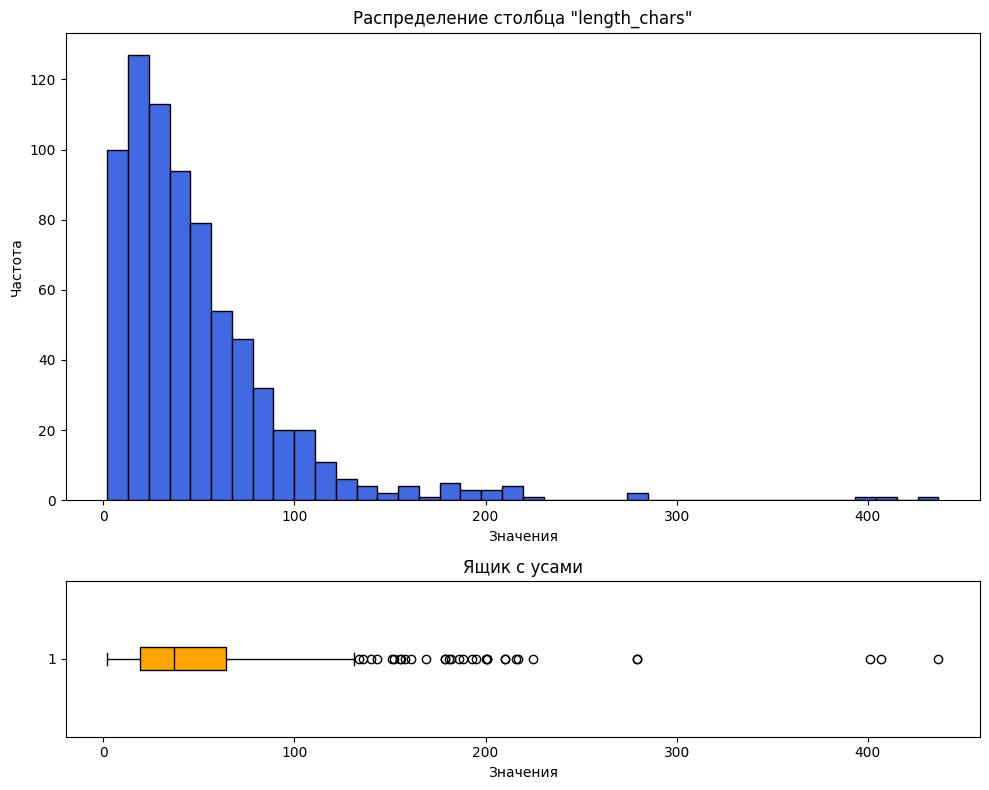

In [17]:
hist_and_boxplot('length_chars')

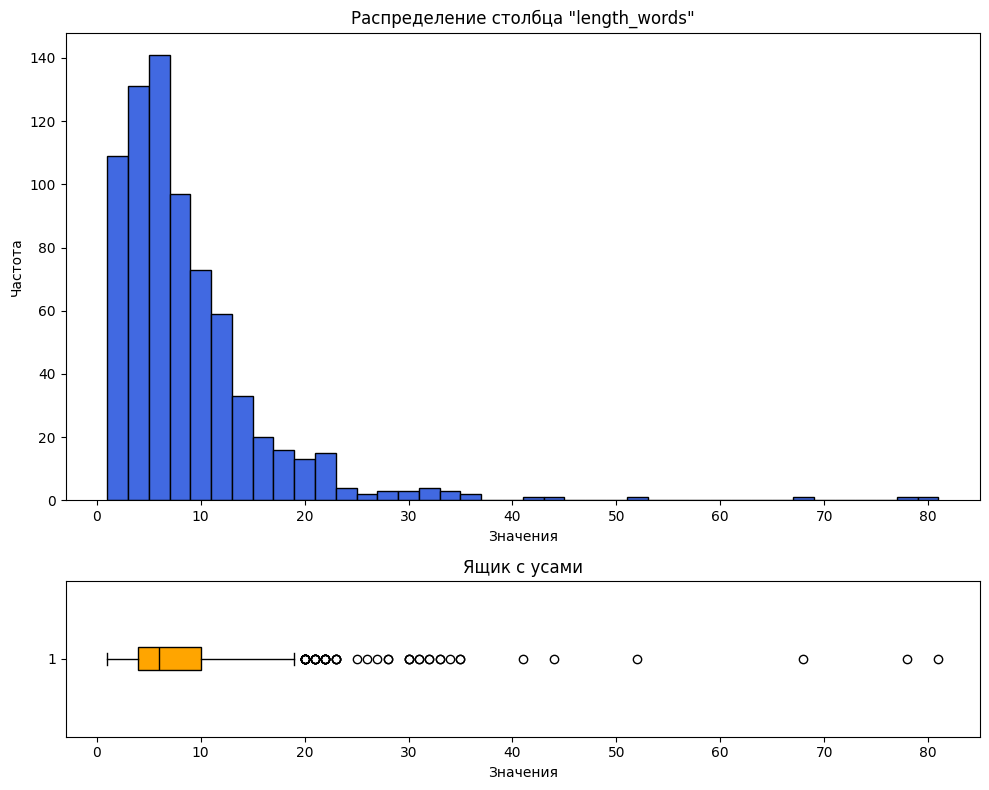

In [18]:
hist_and_boxplot('length_words')

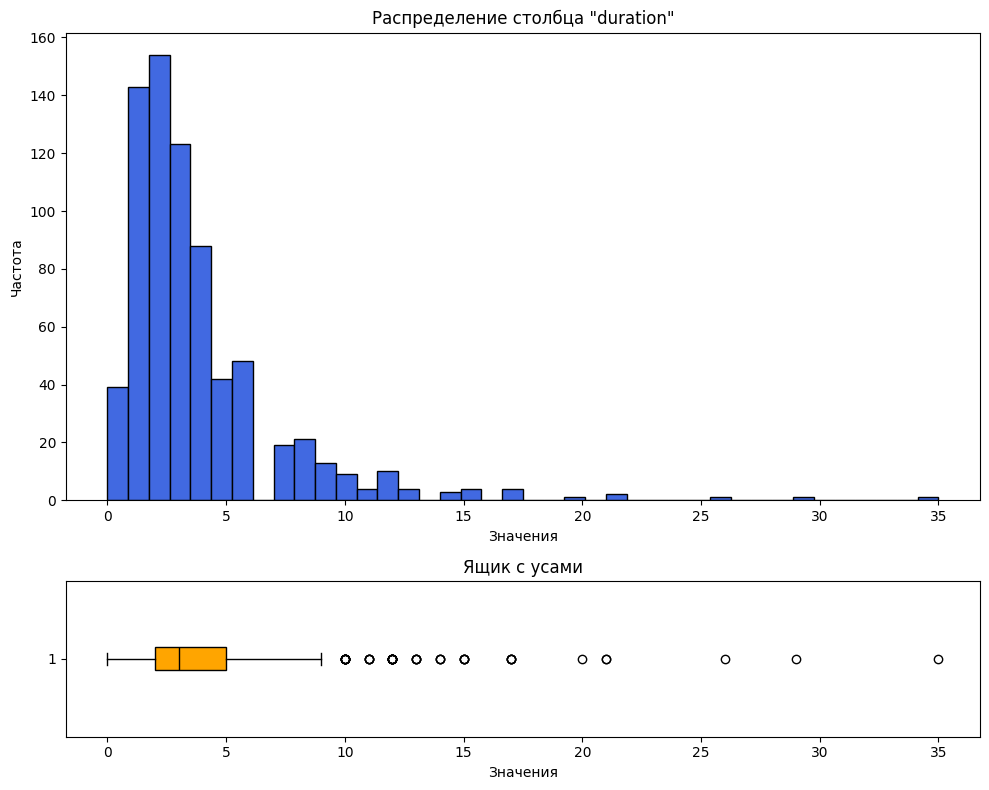

In [19]:
hist_and_boxplot('duration')

С длиной и длительностью сообщений разобрались, перейдем к частоте слов. Стоит сказать, что число небольших сообщений (по объему и длительности) преобладает.<br>Выбросы конечно есть, но их не так много, поэтому не будем брать их во внимание и, тем более, избавляться.<br>Аномалий не обнаружено.

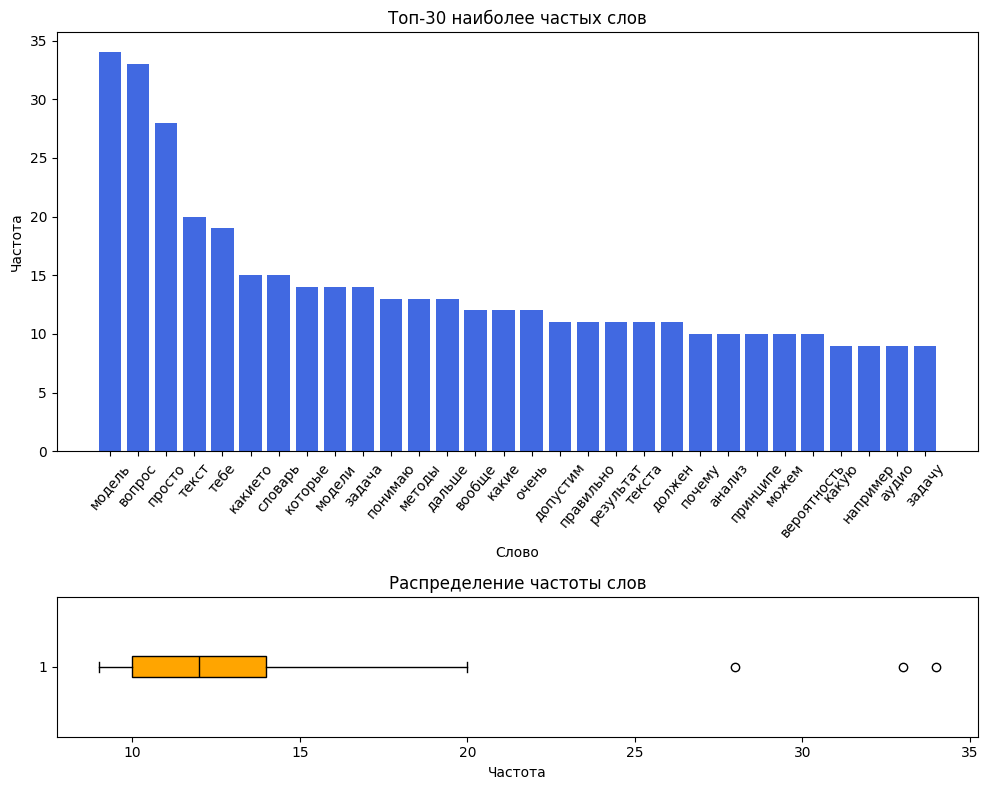

In [20]:
all_text = ' '.join(df['text'].apply(clean))
cleaned_text_without_stopwords = remove_stopwords(all_text)
word_counts = Counter(cleaned_text_without_stopwords.split())

top_words = word_counts.most_common(30)

words, counts = zip(*top_words)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

ax1.bar(words, counts, color='royalblue')
ax1.set_title('Топ-30 наиболее частых слов')
ax1.set_xlabel('Слово')
ax1.set_ylabel('Частота')
ax1.set_xticks(range(len(words)))
ax1.set_xticklabels(words, rotation=50)

ax2.boxplot(counts, vert=False, patch_artist=True,
            boxprops=dict(facecolor='orange', color='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
ax2.set_title('Распределение частоты слов')
ax2.set_xlabel('Частота')

plt.tight_layout()

plt.show()

Гистограмма топ 30 слов по частоте (без стоп слов) показывает хороший результат и шире раскрывает нам 'глаза' на основную тему диалога. Пока что мы не делали лемматизацию, однако стоит отметить, что в обсуждении речь идет о моделях, методах, задачах и прочих понятиях, связанных с машинным обучением.<br>Выбросов еще меньше, чем в предыдущих случаях, также не обращаем внимание.<br>Каких-то резко появившихся аномалий не обнаружено ни на одном графике.

**Промежуточный вывод:**<br>Гистограммы и ящики с усами нам показали многое. Выбросы обнаружены, но на данном этапе мы их оставим, ведь их не так много, и они нам не навредят. Аномалий не обнаружено.<br>Также видно по топ-30 словам по частоте, что в обсуждении речь идет о моделях, методах, задачах и прочих понятиях, связанных с машинным обучением.

**Вывод по шагу 1:**<br>В результате проведенного анализа и визуализации, мы получили полезные инсайты о структуре сообщений и частоте использования слов. Данные подтверждают, что основное обсуждение сосредоточено на моделях и методах машинного обучения. Выбросы и аномалии в частоте слов не оказали существенного влияния на результаты анализа.<br>Для более глубокого понимания тематики и улучшения анализа продолжим работу.

## 2. Анализ эмоциональности текста.

### 2.1. Предобработка текста: токенизация, лемматизация, удаление стоп-слов.

In [21]:
nlp = spacy.load('ru_core_news_sm')

def process_text(text):
    doc = nlp(text.lower())
    processed_tokens = [token.lemma_ for token in doc 
                        if not token.is_stop and not token.is_punct]
    return ' '.join(processed_tokens)

def process_dataframe(df):
    df['processed_text'] = df['text'].apply(process_text)
    return df

df = process_dataframe(df)

df[['text', 'processed_text']].head(15)

,text,processed_text
0,ногами пинаю,нога пинать
1,тут с первой еще надо начинать,первый начинать
2,ты помнишь как все в хамсуэте их ремонтировали,помнить хамсуэте ремонтировать
3,да,
4,а ты не знаешь,знать
5,почему,
6,у меня был такой мониторчик от хампа вот широкий,мониторчик хампа широкий
7,я его тоже лупил он хорошо работал,лупил работать
8,так работай,работай
9,да на всякий случай еще раз всех предупреждаю ...,случай раз предупреждать ставить запись научно...


Мы успешно справились с предобработкой, однако видим, что в некоторых местах образовались пустые строки. Избавимся от них.

In [22]:
df = df.query('processed_text != ""').reset_index()
df[['text', 'processed_text']].head(15)

,text,processed_text
0,ногами пинаю,нога пинать
1,тут с первой еще надо начинать,первый начинать
2,ты помнишь как все в хамсуэте их ремонтировали,помнить хамсуэте ремонтировать
3,а ты не знаешь,знать
4,у меня был такой мониторчик от хампа вот широкий,мониторчик хампа широкий
5,я его тоже лупил он хорошо работал,лупил работать
6,так работай,работай
7,да на всякий случай еще раз всех предупреждаю ...,случай раз предупреждать ставить запись научно...
8,прекрасно,прекрасно
9,поехали,поехать


**Промежуточный вывод:**<br>Нами была проведена предобработка данных, а конкретнее: токенизация, лемматизация и удаление стоп-слов.<br>Судя по по результату, все прошло успешно. От пустых строк мы также избавились и готовы двигаться дальше.

### 2.2. Анализ эмоциональности текста участниов.

Чтобы определить эмоциональность участников было принято разделить эмоции на позитивные, негативные и нейтральные.<br>Для этого с простора интернета был взят датафрейм, содержащий слова и эмоции (соответственно). Используя его, определим эмоции участников разговора.

In [23]:
dictionary = pd.read_csv('/Users/nolvi/Downloads/kartaslovsent.csv', delimiter=';')

In [24]:
dictionary.head()

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19


Датасет качественный, распределим эмоции по словарям и напишем функцию для определения эмоций.

In [25]:
positive_words = dictionary[dictionary['tag'] == 'PSTV']['term'].tolist()
negative_words = dictionary[dictionary['tag'] == 'NGTV']['term'].tolist()

def analyze_sentiment(processed_text):
    words = processed_text.split()
    positive_count = sum(1 for word in words if word in positive_words)
    negative_count = sum(1 for word in words if word in negative_words)
    
    if positive_count > negative_count:
        return 'positive'
    elif negative_count > positive_count:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['processed_text'].apply(analyze_sentiment)

df[['processed_text', 'sentiment']].head(15)

,processed_text,sentiment
0,нога пинать,negative
1,первый начинать,positive
2,помнить хамсуэте ремонтировать,positive
3,знать,positive
4,мониторчик хампа широкий,neutral
5,лупил работать,positive
6,работай,neutral
7,случай раз предупреждать ставить запись научно...,neutral
8,прекрасно,neutral
9,поехать,neutral


**Промежуточный вывод:**<br>Все идет по плану. На первый взгляд, эмоции определились корректно.

### 2.3. Визуализация распредления эмоциональных оценок.

Визуализацию проведем просто. Будем использовать столбчатые диаграммы.

/var/folders/fr/443zwdc97xgg9ycpfypclwzc0000gn/T/ipykernel_890/3911172158.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


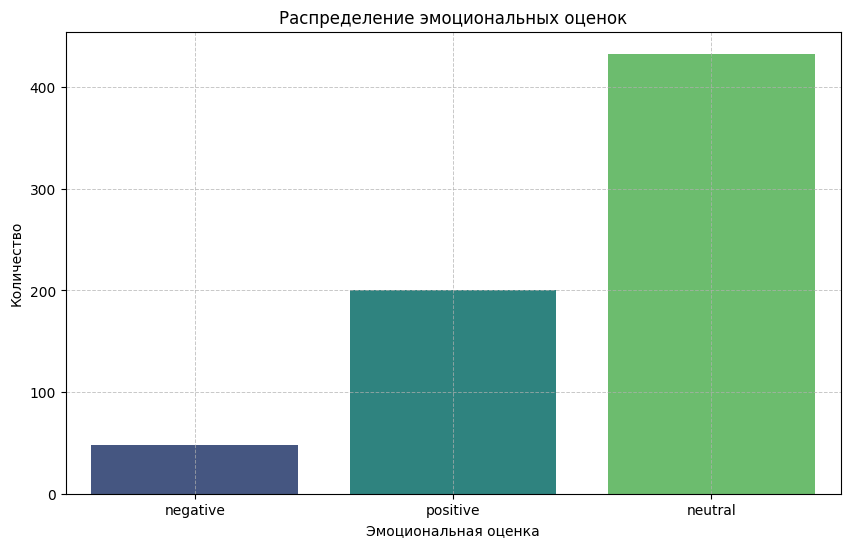

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Распределение эмоциональных оценок')
plt.xlabel('Эмоциональная оценка')
plt.ylabel('Количество')
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

**Промежуточный вывод:**<br>Диаграммы нам показывают, что негативных эмоций мало, позитивных значительно больше, однако еще больше - нейтральных. Это свидетельствует о том, что диалог шел нормально, умеренно, без лишних эмоций, что является хорошим знаком.

**Вывод по шагу 2:**<br>Проведенные предобработка, анализ и визуализация данных показывают, что общение между участниками было в основном конструктивным и позитивным. Основной акцент в диалоге был сделан на нейтральных и положительных аспектах, что является хорошим признаком здоровой рабочей атмосферы.

### 3. Тематическое моделирование.

### 3.1. Обучение и тестирование модели LDA.

Определим основные темы текста, используя методы тематического моделирования.<br>Обучим простую модель LDA и протестируем ее.

In [27]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

vectorizer = CountVectorizer()
train_vec = vectorizer.fit_transform(train_df['processed_text'])
test_vec = vectorizer.transform(test_df['processed_text'])

train_texts = train_df['processed_text'].apply(lambda x: x.split()).tolist()
dictionary = corpora.Dictionary(train_texts)
train_corpus = [dictionary.doc2bow(text) for text in train_texts]

Данные подготовлены, приступим к обучению и подбору гиперпараметров.

In [28]:
lda_model = models.LdaModel(
    corpus=train_corpus,
    id2word=dictionary,
    num_topics=3,
    passes=30,
    alpha='asymmetric',
    eta='auto',
    iterations=400,
    chunksize=2000,
    random_state=RANDOM_STATE,
    eval_every=10
)

Модель обучена, посмотрим на значение когерентности.

In [29]:
coherence_model_lda_train = CoherenceModel(model=lda_model, texts=train_texts, dictionary=dictionary, coherence='c_v')
coherence_score_train = coherence_model_lda_train.get_coherence()
print(f"Значение когерентности на тренировачных данных: {coherence_score_train:.2f}")

Значение когерентности на тренировачных данных: 0.58


Такое значение показывает, что темы имеют умеренную связность и интерпретируемость, то есть темы в целом имеют смысл и содержат слова, которые логически связаны друг с другом.<br>Выведем полученные топики.

In [30]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.021*"текст" + 0.016*"вопрос" + 0.012*"понимать" + 0.011*"модель" + 0.009*"словарь" + 0.009*"раз" + 0.009*"говорить" + 0.009*"ошибка" + 0.008*"слово" + 0.008*"проект"')
(1, '0.019*"задача" + 0.018*"модель" + 0.011*"искусственный" + 0.011*"интеллект" + 0.010*"допустить" + 0.009*"мессенджер" + 0.007*"различный" + 0.006*"тестовый" + 0.006*"качество" + 0.006*"условно"')
(2, '0.020*"знать" + 0.016*"сделать" + 0.016*"задание" + 0.014*"тестовый" + 0.012*"вид" + 0.006*"работать" + 0.006*"модель" + 0.006*"иметься" + 0.005*"обучаться" + 0.005*"общий"')


По идее, все выглядит так, как и должно, а занчит все параметры модели подобраны должным образом.<br>Посмотрим теперь на модель в деле, а именно на ее работу с тестовыми данными.

In [31]:
test_texts = test_df['processed_text'].apply(lambda x: x.split()).tolist()
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

for i, doc in enumerate(test_corpus[:5]):
    topic_distribution = lda_model.get_document_topics(doc)
    print(f"Документ {i}:")
    for topic_num, prop_topic in topic_distribution:
        print(f" Топик {topic_num}: {prop_topic:.4f}")

Документ 0:
 Топик 0: 0.1594
 Топик 1: 0.7667
 Топик 2: 0.0739
Документ 1:
 Топик 0: 0.4766
 Топик 1: 0.3022
 Топик 2: 0.2212
Документ 2:
 Топик 0: 0.8217
 Топик 1: 0.1014
 Топик 2: 0.0769
Документ 3:
 Топик 0: 0.4571
 Топик 1: 0.4684
 Топик 2: 0.0745
Документ 4:
 Топик 0: 0.1592
 Топик 1: 0.7670
 Топик 2: 0.0738


Отсюда виден процент содержания каждого топика в документах (сообщениях).<br>Выведем документы вручную и убедимся в правильности. 

In [32]:
doc_index = [0, 1, 2, 3, 4]
document_text = test_df.iloc[doc_index]['processed_text']
print(f"{document_text}")

648    допустить пятнадцать процент
296                      конкретики
63                     яндекс такси
320        борис присутствие парень
101         искусственный интеллект
Name: processed_text, dtype: object


Если соспоставить топики, полученные проценты содержания каждого топика в документах и сами документы, то видно, что все работает как надо.<br>
**Документ 0:** "допустить пятнадцать процент".
15.94% (Топик 0), 76.67% (Топик 1), 7.39% (Топик 2)
В тексте есть слово "допустить", которое относится к Топику 1. Высокий процент Топика 1 логичен, так как это слово присутствует в словарном запасе Топика 1.<br>
**Документ 1:** "конкретики".
47.66% (Топик 0), 30.22% (Топик 1), 22.12% (Топик 2)
Слово "конкретики" явно не совпадает с основными словами в выделенных топиках, что может объяснять более равномерное распределение по темам, так как модель могла столкнуться с неопределенностью.<br>
**Документ 2:** "яндекс такси".
82.17% (Топик 0), 10.14% (Топик 1), 7.69% (Топик 2)
Слова "яндекс" и "такси" не относятся напрямую к каким-либо топикам, но высокий процент Топика 0 может быть случайным распределением, учитывая, что в этом топике есть слова, связанные с текстом и общими понятиями.<br>
**Документ 3:** "борис присутствие парень".
45.71% (Топик 0), 46.84% (Топик 1), 7.45% (Топик 2)
Здесь распределение между Топиками 0 и 1 примерно равное, что может означать, что модель нашла слова, отчасти связанные с обоими топиками. Однако, здесь связь не столь очевидна.<br>
**Документ 4:** "искусственный интеллект".
15.92% (Топик 0), 76.70% (Топик 1), 7.38% (Топик 2)
Этот документ явно связан с Топиком 1, где "искусственный интеллект" является одним из ключевых слов, что подтверждает корректную работу модели.

**Промежуточный вывод:**<br>Стоит сказать, что обученная нами модель в основном работает корректно, особенно на документах, содержащих слова, связанные с выделенными топиками. Однако, для некоторых документов, где ключевые слова не столь явные, модель может показывать менее точные результаты, но это нормально для LDA.

### 3.2. Визуализация результатов тематического моделирования.

Для визуализации будем использовать pyLDAvis. С помощью данного инструмента мы увидим на какие темы разделяется текст.

In [33]:
pyLDAvis.enable_notebook()

panel = gensimvis.prepare(lda_model, train_corpus, dictionary, R=10)

panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.113931 -0.015996       1        1  67.330353
1     -0.076140 -0.063288       2        1  21.045630
2     -0.037791  0.079284       3        1  11.624016, topic_info=              Term       Freq      Total Category  logprob  loglift
110          знать   7.000000   7.000000  Default  10.0000  10.0000
178         задача  16.000000  16.000000  Default   9.0000   9.0000
28         задание   5.000000   5.000000  Default   8.0000   8.0000
30         сделать   5.000000   5.000000  Default   7.0000   7.0000
31        тестовый   6.000000   6.000000  Default   6.0000   6.0000
285            вид   5.000000   5.000000  Default   5.0000   5.0000
54          модель  25.000000  25.000000  Default   4.0000   4.0000
115  искусственный   5.000000   5.000000  Default   3.0000   3.0000
114      интеллект   5.000000   5.000000  Default   2.0000   2.0000
141      допустить   5.000000   5.000000  Default   1.0000   1.0000
59          вопрос  23.368467  23.760240   Topic1  -4.1406   0.3789
96          ошибка  13.353472  13.740458   Topic1  -4.7002   0.3670
126        словарь  13.918224  14.436026   Topic1  -4.6588   0.3590
84       результат   9.507174   9.886916   Topic1  -5.0399   0.3564
93        понимать  18.278435  19.052794   Topic1  -4.3863   0.3541
36          делать   8.736010   9.115870   Topic1  -5.1245   0.3530
201       смотреть   8.734140   9.115129   Topic1  -5.1247   0.3529
24           какой   8.716799   9.111133   Topic1  -5.1267   0.3513
106       параметр   6.424098   6.803113   Topic1  -5.4319   0.3382
2       предлагать   6.422913   6.802864   Topic1  -5.4321   0.3381
67           текст  30.877127  32.717782   Topic1  -3.8620   0.3377
13        говорить  13.520163  14.408693   Topic1  -4.6878   0.3319
139        человек  11.931281  12.734849   Topic1  -4.8128   0.3304
49           слово  12.366507  13.572542   Topic1  -4.7770   0.3025
79          проект  12.304250  13.559363   Topic1  -4.7820   0.2984
131            раз  13.838170  15.742555   Topic1  -4.6645   0.2666
54          модель  15.948306  25.911545   Topic1  -4.5226  -0.0898
141      допустить   4.657845   5.113752   Topic2  -4.5905   1.4651
123     мессенджер   4.046724   4.475875   Topic2  -4.7312   1.4577
115  искусственный   5.212091   5.779087   Topic2  -4.4781   1.4552
114      интеллект   5.212043   5.779096   Topic2  -4.4781   1.4552
407      различный   3.381248   3.840342   Topic2  -4.9108   1.4312
284       услышать   2.768036   3.195870   Topic2  -5.1109   1.4148
649    происходить   2.131377   2.555221   Topic2  -5.3723   1.3771
454          стена   2.127743   2.556055   Topic2  -5.3740   1.3751
453         крутой   2.127738   2.556056   Topic2  -5.3740   1.3751
452       классный   2.127738   2.556056   Topic2  -5.3740   1.3751
178         задача   8.611132  16.882816   Topic2  -3.9760   0.8852
117        условно   2.793656   3.701277   Topic2  -5.1017   1.2772
54          модель   8.330801  25.911545   Topic2  -4.0091   0.4237
337       работать   2.760968   4.686336   Topic2  -5.1135   1.0294
31        тестовый   2.871897   6.698634   Topic2  -5.0741   0.7115
318       качество   2.810341   7.042010   Topic2  -5.0958   0.6399
28         задание   4.049531   5.411994   Topic3  -4.1368   1.8621
322         faster   1.155670   1.626059   Topic3  -5.3908   1.8106
328        виспера   1.155503   1.626132   Topic3  -5.3909   1.8104
56         сиквенс   1.155264   1.626249   Topic3  -5.3911   1.8101
617     постоянный   1.154908   1.626438   Topic3  -5.3914   1.8097
616    пользование   1.154903   1.626441   Topic3  -5.3914   1.8097
30         сделать   4.091475   5.888723   Topic3  -4.1265   1.7880
110          знать   5.029276   7.683670   Topic3  -3.9202   1.7283
570          ктото   1.025443   1.698037   Topic3  -5.5103   1.6477
228        иметься   1.624440   2.774954   Topic3  -5.0503   1.6166
285            

**Промежуточный вывод:**<br>"Пузыри" наглядно показывают нам, что разбиение на темы прошло успешно.<br>Все пузыри находятся в разных плоскостях и не пересекаются - это признак хорошей тематической модели.<br>
Я думаю, что темам можно дать следующие характеристики и названия:<br>
**Тема 1: "Текст в моделях машинного обучения".**
Эта тема охватывает обсуждения, связанные с обработкой текстов, использованием словарей и корректностью моделей машинного обучения.<br>
**Тема 2: "Задачи и качество искусственного интеллекта".**<br>
Эта тема связана с задачами, в которых используются модели искусственного интеллекта, и обсуждением их качества и эффективности.<br>
**Тема 3: "Тестовые задания и знания".**<br>
Эта тема охватывает вопросы, связанные с выполнением тестовых заданий, обучением и применением знаний.

**Вывод по шагу 3:**<br>Созданная нами модель LDA успешно выделяет темы в текстах и корректно распределяет их по документам. Визуализация pyLDAvis подтверждает, что модель разделяет темы достаточно чётко, что делает её пригодной для анализа и интерпретации текстовых данных в контексте обсуждаемых тем.

## Подведение итогов.

**Общий вывод:**<br>В рамках данного проекта был проведен комплексный анализ текстового файла в формате DOCX, содержащего диалог с совещания. В анализе использовались методы обработки естественного языка и анализа данных. Целью было углубленное понимание содержания совещания, выявление эмоциональных настроений участников и определение основных тем обсуждения.<br><br>1) В ходе исследовательского анализа данных были изучены структура сообщений и частота использования слов. Анализ показал, что основное обсуждение сосредоточено на моделях и методах машинного обучения. Выбросы и аномалии в частоте слов не оказали значительного влияния на результаты анализа. Основные инсайты подтверждают, что содержание совещания в основном связано с темами машинного обучения. Для дальнейшего углубленного анализа планируется продолжение работы.<br><br>2) Проведенный анализ эмоциональности текста показал, что общение между участниками было в основном конструктивным и позитивным. В тексте преобладает нейтральный и положительный тон, что свидетельствует о здоровой и продуктивной рабочей атмосфере.<br><br>3) Созданная модель LDA успешно выделяет темы в текстах и корректно распределяет их по документам. Визуализация с использованием pyLDAvis подтверждает четкость разделения тем, что делает модель пригодной для анализа и интерпретации текстовых данных.<br><br>Темы, выявленные моделью:<br>"Текст в моделях машинного обучения";<br>"Задачи и качество искусственного интеллекта";<br>"Тестовые задания и знания".<br><br>Делаем вывод, что основное обсуждение сосредоточено на моделях машинного обучения и искусственном интеллекте. Текст демонстрирует конструктивную и позитивную рабочую атмосферу, где участники вели обсуждение по ключевым вопросам, связанным с моделями МО (ИИ) и выполнением тестовых заданий.<br><br>Проведенный анализ показывает, что используемые методы обработки текста и тематического моделирования позволяют эффективно извлекать и интерпретировать ключевые темы обсуждений. Полученные результаты дают ясное представление о содержании совещания, эмоциональном фоне и основных обсуждаемых темах.